<a href="https://www.kaggle.com/code/karan842/pneumonia-detection-with-vgg19-91?scriptVersionId=91742044" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# AI for Medical Diagnoisis:
Computer Vision has a lot of applications in medical diagnosis:
- Dermatology
- Ophthakmology
- Histopathlogy

Perhaps, `X-rays` images are critical for the detection of lung cancer, pneumenia ... 

Steps are: 

- Data pre-processing
- Preprocess images properly for the train, validation and test sets.
- Set-up a pre-trained neural network to make disease predictions on chest X-rays.

# What is Pneumonia?

- Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

- Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

![pneumonia](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSPPW6B1QQMf3UDXkwO3RmJl1qLPPIfuDmX2w&usqp=CAU)

# Importing necessary libraries

In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

## Loading the data

In [3]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
val_dir = "../input/chest-xray-pneumonia/chest_xray/val"

In [4]:
print("Train set:")
print("-"*60)
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("\nTest set:")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("\nValidation set")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir = "../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

Train set:
------------------------------------------------------------
PNEUMONIA=3875
NORMAL=1341

Test set:
------------------------------------------------------------
PNEUMONIA=390
NORMAL=234

Validation set
------------------------------------------------------------
PNEUMONIA=8
NORMAL=8


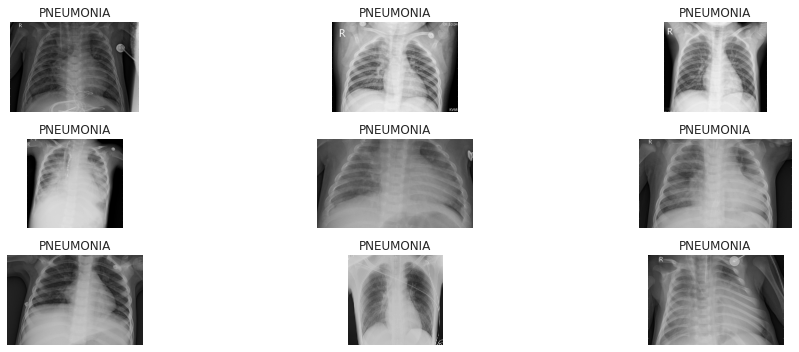

In [5]:
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("PNEUMONIA")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    

plt.tight_layout()

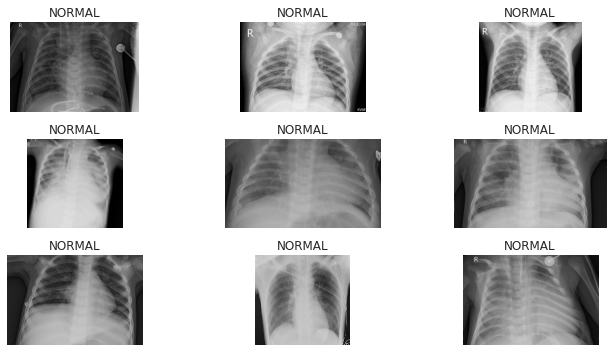

In [6]:
normal = os.listdir("../input/chest-xray-pneumonia/chest_xray/train/NORMAL")
normal_dir = "../input/chest-xray-pneumonia/chest_xray/train/NORMAL"

plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()


In [7]:
import glob

pneumonia_train = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir+"/NORMAL/*.jpeg")

In [8]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train) , [1]*len(pneumonia_train)]),columns=["class"])

`0 - NORMAL || 1 - PNEUMONIA`

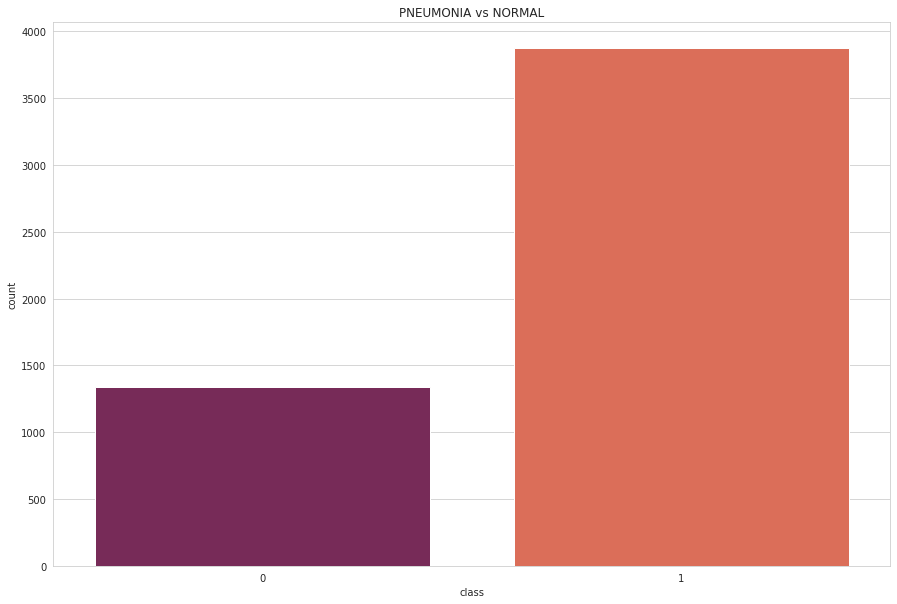

In [9]:
plt.figure(figsize=(15,10))
sns.countplot(data['class'],data=data,palette='rocket')
plt.title('PNEUMONIA vs NORMAL')
plt.show()

## Data Augmentation
- Using `ImageDataGenerator`, to augment our images so as to create a larger dataset for our model to train on.

2. Also deal wit imbalances number of data points of the given classes.

In [40]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [61]:
train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=8,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=1,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = img_Datagen.flow_from_directory(test_dir,
                                       batch_size=1,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [62]:
img, label = next(train)
img.shape

(8, 256, 256, 3)

# Defining the model
- Using pre-trainied VGG19 model.
- Freezing all the layers of model of train.
- Using Adam as optimizer

In [63]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [64]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [65]:
# len(validation)/32

In [66]:
history = model.fit(train,epochs=20, 
                    validation_data=validation,
                     steps_per_epoch=100,
#                     callbacks=[early_stopping],
                    batch_size=32)

Epoch 1/20
100/100 [==============================] - 21s 201ms/step - loss: 0.5131 - accuracy: 0.7513 - val_loss: 0.6595 - val_accuracy: 0.5625
Epoch 2/20
100/100 [==============================] - 18s 184ms/step - loss: 0.3499 - accuracy: 0.8487 - val_loss: 0.5554 - val_accuracy: 0.7500
Epoch 3/20
100/100 [==============================] - 19s 193ms/step - loss: 0.3341 - accuracy: 0.8388 - val_loss: 0.8232 - val_accuracy: 0.6250
Epoch 4/20
100/100 [==============================] - 19s 186ms/step - loss: 0.3275 - accuracy: 0.8388 - val_loss: 0.7282 - val_accuracy: 0.6250
Epoch 5/20
100/100 [==============================] - 19s 193ms/step - loss: 0.3157 - accuracy: 0.8600 - val_loss: 0.5113 - val_accuracy: 0.7500
Epoch 6/20
100/100 [==============================] - 18s 185ms/step - loss: 0.2725 - accuracy: 0.8813 - val_loss: 0.4433 - val_accuracy: 0.6875
Epoch 7/20
100/100 [==============================] - 20s 195ms/step - loss: 0.2872 - accuracy: 0.8800 - val_loss: 0.4846 - val_ac

# Evaluating the VGG19

In [73]:
# Evaluating the model on traina and test
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

652/652 [==============================] - 121s 185ms/step - loss: 0.2143 - accuracy: 0.9193
Train Loss:  0.21428963541984558
Train Accuracy:  0.9192867875099182


In [74]:
# Test data
score = model.evaluate(test)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

624/624 [==============================] - 15s 24ms/step - loss: 0.3148 - accuracy: 0.8926
Test Loss:  0.3148472309112549
Test Accuracy:  0.8926281929016113


Text(0.5, 1.0, 'Accuracy Evolution')

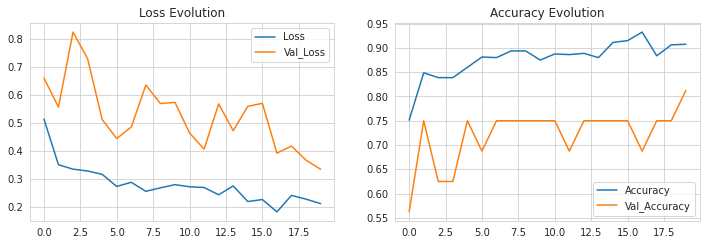

In [75]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [90]:
# from sklearn.metrics import confusion_matrix, classification_report
# pred = model.predict(test)

# print("Confusion matrix")
# cm = confusion_matrix(test.classes, pred>0.5)*100
# ax= plt.subplot()
# sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

# # labels, title and ticks
# ax.set_xlabel('Predicted labels')
# ax.set_ylabel('True labels')
# ax.set_title('Confusion Matrix')
# ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
# ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])

In [92]:
# print(cm)

In [93]:
# print("Classification Report: \n")
# print(classification_report(test.classes, pred>0.5))


In [94]:
# from sklearn.metrics import accuracy_score

# print(accuracy_score(test.classes,pred>0.5))

After first try model doesn't predict good accuracy score on test classes. Further I wil be using other pre trained models and fine tuning. Stay tune!